<a href="https://colab.research.google.com/github/VTNay/MEC557-Project/blob/Ma/MEC557_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Weather station

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/map.png?raw=1" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### Data set

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/annual_temperature.png?raw=1" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

# Data processing

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from functools import reduce
from matplotlib import pyplot as plt
from sklearn import preprocessing

# Define file paths for weather data of different cities
weather_paths = {
    'Paris': Path('/content/drive/My Drive/PHY557_Project/weather/paris'),
    'Brest': Path('/content/drive/My Drive/PHY557_Project/weather/brest'),
    'London': Path('/content/drive/My Drive/PHY557_Project/weather/london'),
    'Marseille': Path('/content/drive/My Drive/PHY557_Project/weather/marseille'),
    'Berlin': Path('/content/drive/My Drive/PHY557_Project/weather/berlin')
}

# Define the names of the files for each weather parameter
file_names = {
    't2m': 't2m.nc', 'blh': 'blh.nc', 'd2m': 'd2m.nc', 'skt': 'skt.nc',
    'sp': 'sp.nc', 'ssrd': 'ssrd.nc', 'tcc': 'tcc.nc', 'tp': 'tp.nc',
    'u10': 'u10.nc', 'v10': 'v10.nc'
}

# Initialize a dictionary to store weather data for each city
weather_data = {city: {} for city in weather_paths}

# Load and preprocess the data for each city
for city, path in weather_paths.items():
    for param, file_name in file_names.items():
        # Load the dataset
        dataset = xr.open_dataset(Path(path, file_name)).to_dataframe()
        # Drop unnecessary levels based on the parameter
        if param in ['d2m', 'blh']:
            dataset = dataset.droplevel([1, 2])
        else:
            dataset = dataset.droplevel([0, 1])
        # Store the processed data
        weather_data[city][param] = dataset
    # Merge data from different parameters into a single dataframe
    weather_data[city] = reduce(lambda left, right: pd.merge(
        left, right, left_index=True, right_index=True, how='outer'),
        weather_data[city].values())

# Function to rename columns with city prefix
def rename_columns(df, prefix):
    """Rename columns with a city prefix."""
    return df.rename(columns={col: f"{prefix}_{col}" for col in df.columns})

# Rename columns and concatenate data from all cities
combined_data = pd.concat([rename_columns(weather_data[city], city) for city in weather_data], axis=1)

# Data cleaning
# Drop rows with missing values
combined_data = combined_data.dropna()

# Split the combined data into features (X) and target (y)
X_raw = combined_data.iloc[:,10:]  # Features from all cities except Paris
y = combined_data['Paris_t2m']  # Target: temperature in Paris

# Assuming X_raw and y are your raw data arrays
X_normalized = (X_raw - X_raw.mean())/X_raw.std()
y_normalized = (y - y.mean())/y.std()


# Calculate the number of years in the dataset
n_years = y_normalized.index.year.max() - y_normalized.index.year.min() + 1

print(X_normalized.columns)
print('Number of years: {}'.format(n_years))

Index(['Brest_t2m', 'Brest_blh', 'Brest_d2m', 'Brest_skt', 'Brest_sp',
       'Brest_ssrd', 'Brest_tcc', 'Brest_tp', 'Brest_u10', 'Brest_v10',
       'London_t2m', 'London_blh', 'London_d2m', 'London_skt', 'London_sp',
       'London_ssrd', 'London_tcc', 'London_tp', 'London_u10', 'London_v10',
       'Marseille_t2m', 'Marseille_blh', 'Marseille_d2m', 'Marseille_skt',
       'Marseille_sp', 'Marseille_ssrd', 'Marseille_tcc', 'Marseille_tp',
       'Marseille_u10', 'Marseille_v10', 'Berlin_t2m', 'Berlin_blh',
       'Berlin_d2m', 'Berlin_skt', 'Berlin_sp', 'Berlin_ssrd', 'Berlin_tcc',
       'Berlin_tp', 'Berlin_u10', 'Berlin_v10'],
      dtype='object')
Number of years: 40


**PCA**

In [3]:
from sklearn.decomposition import PCA
import pandas as pd

def apply_pca(X, n_components=20):
    """
    Applies PCA to reduce the number of features.
    Args:
    X (DataFrame): The input features dataset.
    n_components (int): The number of principal components to keep.
    Returns:
    DataFrame: Transformed feature set with reduced dimensions.
    """
    # Initialize PCA
    pca = PCA(n_components=n_components)
    # Fit PCA on the dataset
    pca.fit(X)
    # Transform the dataset
    X_pca = pca.transform(X)
    # Convert to DataFrame for easier handling
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    return X_pca_df
# Example usage
# Assuming X_raw is your original dataset with 40 features
# X_reduced = apply_pca(X_raw, n_components=20)

Lasso is a linear model that uses this cost function:

$$
\frac{1}{2N_{\text{training}}} \sum_{i=1}^{N_{\text{training}}} \left( y^{(i)}_{\text{real}} - y^{(i)}_{\text{pred}} \right)^2 + \alpha \sum_{j=1}^{n} |a_j|
$$

$a_j$ is the coefficient of the j-th feature. The final term is called $l_1$ penalty and $\alpha$ is a hyperparameter that tunes the intensity of this penalty term. The higher the coefficient of a feature, the higher the value of the cost function. So, the idea of Lasso regression is to optimize the cost function reducing the absolute values of the coefficients.


In [4]:
from sklearn.linear_model import LassoCV
import pandas as pd

def apply_lasso(X, y, n_features_to_select):
    """
    Applies Lasso regression to select features.

    Args:
    X (DataFrame): The input features dataset.
    y (Series): The target dataset.
    n_features_to_select (int): The desired number of features to select.

    Returns:
    DataFrame: The reduced feature set.
    List of tuples: The list of features with their corresponding absolute coefficient values.
    """
    # Initialize LassoCV with cross-validation to find the optimal alpha
    lasso = LassoCV(cv=5)

    # Fit LassoCV on the dataset
    lasso.fit(X, y)

    # Get the coefficients
    coef = lasso.coef_

    # Combine features with their coefficients
    feature_coef = list(zip(X.columns, abs(coef)))

    # Sort features by the absolute value of their coefficient
    feature_coef = sorted(feature_coef, key=lambda x: x[1], reverse=True)

    # Select the top 'n_features_to_select'
    selected_features = [feature for feature, _ in feature_coef[:n_features_to_select]]

    return X[selected_features], feature_coef

# Example usage
# Assuming X and y are your datasets
# X_reduced, feature_importances = apply_lasso(X, y, n_features_to_select=20)


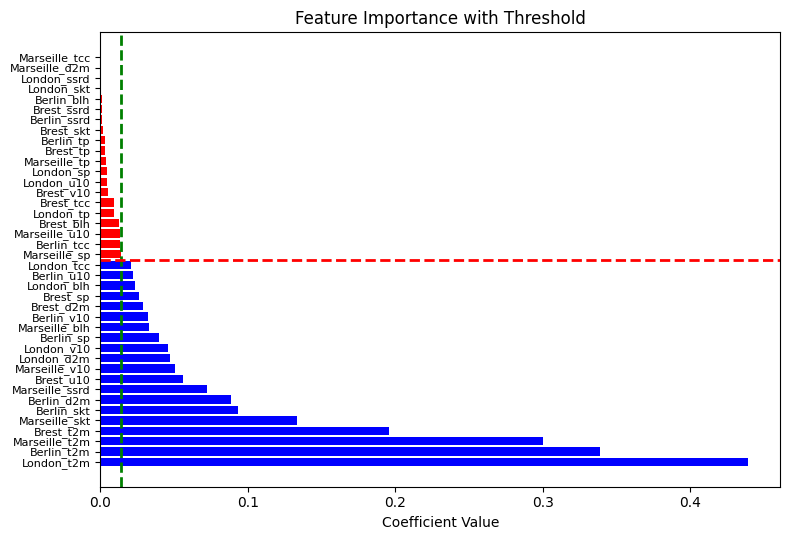

In [5]:
X_lasso, feature_coef = apply_lasso(X_normalized, y_normalized, 20)
# Convert the list of tuples to a DataFrame for easier plotting
features, coefficients = zip(*feature_coef)
df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Determine the threshold for the top 3 features
top_20_threshold = df['Coefficient'].nlargest(21).min()

# Create a color list, where features above the threshold are 'red' and others are 'blue'
colors = ['blue' if x > top_20_threshold else 'red' for x in df['Coefficient']]

# Plot the horizontal bar plot
plt.figure(figsize=(8, 5.5))
bars = plt.barh(df['Feature'], df['Coefficient'], color=colors)

# Add a vertical line for the threshold of the top 3 features
plt.axvline(x=top_20_threshold, color='green', linestyle='--', linewidth=2)

# Add a horizontal line at the position of the 3rd feature
top_20_feature_position = df[df['Coefficient'] > top_20_threshold].shape[0]
plt.axhline(y=top_20_feature_position-0.5, color='red', linestyle='--', linewidth=2)

plt.xlabel('Coefficient Value')
plt.yticks(fontsize = 8)
plt.title('Feature Importance with Threshold')
plt.tight_layout()

# Show the plot
plt.show()

## Core Fucntion ##

In [6]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

def poly_ridge(degree, X, y, alpha_values, n_splits_cv, test_size):
    """
    Performs polynomial regression with Ridge regularization.

    Args:
    degree (int): The degree of the polynomial features.
    X (DataFrame): The features dataset.
    y (Series): The target dataset.
    alpha_values (array): Array of alpha values for regularization.
    n_splits_cv (int): Number of splits for cross-validation.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    dict: A dictionary containing model performance metrics and optimal parameters.
    """

    # Split the dataset into training and testing sets
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # Initialize arrays for storing scores and coefficients
    r2_validation = np.empty(len(alpha_values))

    # Loop over different values of alpha (regularization strength)
    for i, alpha in enumerate(alpha_values):
        # Transform data to include polynomial features, include_bias=False because Ridge has the intercept by default
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        # Create a pipeline with polynomial features and ridge regression
        model = make_pipeline(polynomial_features, Ridge(alpha=alpha))

        # Calculate the mean R^2 score from k-fold cross-validation
        r2_validation[i] = cross_val_score(model, X_cv, y_cv, cv=n_splits_cv).mean()

    # Find the index of the best alpha value
    i_best = np.argmax(r2_validation)
    alpha_best = alpha_values[i_best]

    # Train the model with the best alpha value on the full CV dataset
    best_model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), Ridge(alpha=alpha_best))
    best_model.fit(X_cv, y_cv)

    # Calculate R^2 score on the test dataset
    r2_test = best_model.score(X_test, y_test)

    # Return a dictionary containing the results
    return {
        'r2_validation': r2_validation,
        'i_best': i_best,
        'alpha_best': alpha_best,
        'r2_test': r2_test
    }

In [7]:

# Example usage
# results = poly_ridge(degree=3, X=X_normalized, y=y_normalized, alpha_values=np.logspace(-4, 4, 10), n_splits_cv=5, test_size=0.25)
# print(results)

# Results

## 40 features

We don't have enough memory to run the third degree polynomial with 40 features, so in this case we will examine only the ridge regression for linear and second degree polynomial

In [8]:
alpha_values_40 =np.logspace(-4, 4, 10)

In [9]:
# Degree 1
results_40_linear = poly_ridge(degree=1, X=X_normalized, y=y_normalized, alpha_values=alpha_values_40, n_splits_cv=5, test_size=0.25)
print(results_40_linear)

{'r2_validation': array([0.91979408, 0.91979408, 0.91979408, 0.91979407, 0.91979408,
       0.91979407, 0.91979388, 0.91978108, 0.91932144, 0.91427956]), 'i_best': 0, 'alpha_best': 0.0001, 'r2_test': 0.9205143468647179}


In [ ]:
# Degree 2
results_40_second = poly_ridge(degree=2, X=X_normalized, y=y_normalized, alpha_values=alpha_values_40, n_splits_cv=5, test_size=0.25)

In [11]:
print(results_40_second)

{'r2_validation': array([0.94159705, 0.94159705, 0.94159704, 0.94159706, 0.94159731,
       0.94159811, 0.94159302, 0.94151145, 0.94071196, 0.93618833]), 'i_best': 5, 'alpha_best': 2.782559402207126, 'r2_test': 0.9418065467502197}


## 20 features

In [13]:
alpha_values_20 =np.logspace(-4, 4, 10)

### Getting the results for 20 features (PCA)

In [14]:
X_20_PCA = apply_pca(X_normalized, 20)
alpha_values_20_PCA =np.logspace(-4, 4, 10)

In [15]:
# Degree 1
results_20_linear_PCA = poly_ridge(degree=1, X=X_20_PCA, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)
print(results_20_linear_PCA)

{'r2_validation': array([0.90027472, 0.90027472, 0.90027472, 0.90027472, 0.90027472,
       0.90027472, 0.90027472, 0.9002747 , 0.90027256, 0.90015842]), 'i_best': 6, 'alpha_best': 21.54434690031882, 'r2_test': 0.9004984622804788}


In [16]:
# Degree 2
results_20_second_PCA = poly_ridge(degree=2, X=X_20_PCA, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)
print(results_20_second_PCA)

{'r2_validation': array([0.91563004, 0.91563004, 0.91563004, 0.91563004, 0.91563004,
       0.91563005, 0.9156301 , 0.91563039, 0.91562763, 0.91542057]), 'i_best': 7, 'alpha_best': 166.81005372000558, 'r2_test': 0.9159360096197793}


In [ ]:
# Degree 3
results_20_third_PCA = poly_ridge(degree=3, X=X_20_PCA, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)

In [20]:
print(results_20_third_PCA)

{'r2_validation': array([0.92558642, 0.92558642, 0.92558625, 0.92558644, 0.92558632,
       0.92558678, 0.9255877 , 0.9255944 , 0.92555541, 0.92463696]), 'i_best': 7, 'alpha_best': 166.81005372000558, 'r2_test': 0.9263174718020803}


### Getting the results for 20 features (Lasso)

In [23]:
X_20_Lasso, feature_coef = apply_lasso(X_normalized, y_normalized, 20)
alpha_values_20_Lasso =np.logspace(-4, 4, 10)

In [24]:
# Degree 1
results_20_linear_Lasso = poly_ridge(degree=1, X=X_20_Lasso, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)
print(results_20_linear_Lasso)

{'r2_validation': array([0.91897913, 0.91897913, 0.91897913, 0.91897914, 0.91897914,
       0.91897914, 0.91897899, 0.91897027, 0.91863328, 0.91409492]), 'i_best': 5, 'alpha_best': 2.782559402207126, 'r2_test': 0.9196585752223251}


In [25]:
# Degree 2
results_20_second_Lasso = poly_ridge(degree=2, X=X_20_Lasso, y=y_normalized, alpha_values=alpha_values_20_Lasso, n_splits_cv=5, test_size=0.25)
print(results_20_second_Lasso)

{'r2_validation': array([0.93595817, 0.93595817, 0.93595817, 0.93595819, 0.93595818,
       0.93595818, 0.93595411, 0.9358954 , 0.9351684 , 0.92989065]), 'i_best': 3, 'alpha_best': 0.046415888336127774, 'r2_test': 0.9361751343624192}


In [ ]:
# Degree 3
results_20_third_Lasso = poly_ridge(degree=3, X=X_20_Lasso, y=y_normalized, alpha_values=alpha_values_20_Lasso, n_splits_cv=5, test_size=0.25)

In [27]:
print(results_20_third_Lasso)

{'r2_validation': array([0.94322811, 0.9432281 , 0.94322811, 0.92771522, 0.94286743,
       0.94079323, 0.94424622, 0.94410242, 0.94310298, 0.93949173]), 'i_best': 6, 'alpha_best': 21.54434690031882, 'r2_test': 0.9444842937543287}


## Plot the figures

### Plot_3d function

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d(models, alpha_values, r2_validation_arrays):
    """
    Plots a 3D of ridge curves of different models .

    Parameters:
    models (list): A list of models for the X-axis.
    alpha_values (array): An array of alpha values for the Y-axis.
    r2_validation_arrays (list of arrays): A list of r2_validation for the Z-axis, each corresponding to a model.
    """
    X, Y = np.meshgrid(range(1, len(models) + 1), alpha_values)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set the positions for the labels to be closer
    label_positions = np.linspace(1, 1.2, len(labels))
    for i, (label, z) in enumerate(zip(models, r2_validation_arrays)):
        X = np.full_like(z, label_positions[i])  # Adjusting label positions
        Y = alpha_values
        ax.scatter(X, np.log10(Y), z, label=models)  # Apply log scale transformation

    ax.set_xlabel('Models')
    ax.set_ylabel('Alpha Values')
    ax.set_zlabel('R2 validation')
    ax.set_title('Ridge regression with several models')
    ax.set_xticks(label_positions)
    ax.set_xticklabels(models)
    # Set the y ticks to represent the log scale
    y_ticks = np.logspace(np.log10(alpha_values.min()), np.log10(alpha_values.max()), num=5)
    ax.set_yticks(np.log10(y_ticks))
    ax.set_yticklabels(y_ticks)
    plt.show()


In [92]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d(models, alpha_values, r2_validation_arrays):
    """
    Plots a 2D of ridge curves of different models .

    Parameters:
    models (list): A list of models for the X-axis.
    alpha_values (array): An array of alpha values for the Y-axis.
    r2_validation_arrays (list of arrays): A list of r2_validation for the Z-axis, each corresponding to a model.
    """
    # Set up the plot
    fig, ax = plt.subplots()

    # Plot each set of data
    for i,z in enumerate(r2_validation_arrays):
        ax.scatter(alpha_values, z, label=f"{models[i]}")

    ax.set_xscale('log')
    ax.set_xlabel('Alpha values')
    ax.set_ylabel('R2 validation')
    ax.set_title('Ridge regression with several models')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=2)

    plt.show()

### 40 features figures

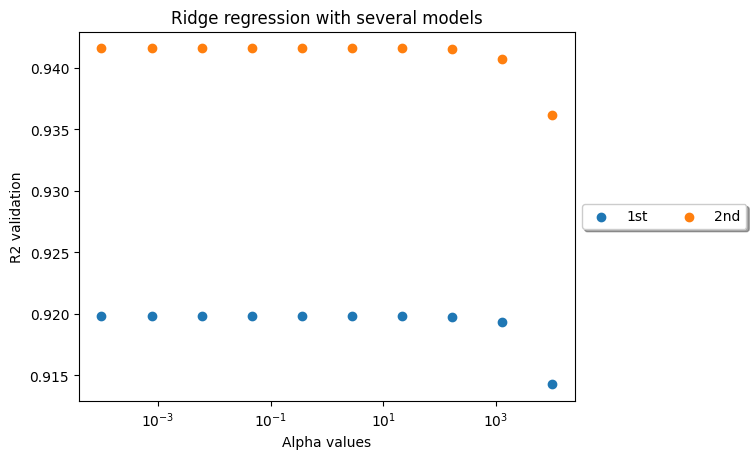

In [93]:
# 2D plot
models = ['1st', '2nd']
alpha_values = alpha_values_40
z_1st = results_40_linear['r2_validation']
z_2nd = results_40_second['r2_validation']
plot_2d(models, alpha_values, [z_1st, z_2nd])

### 20 features figures

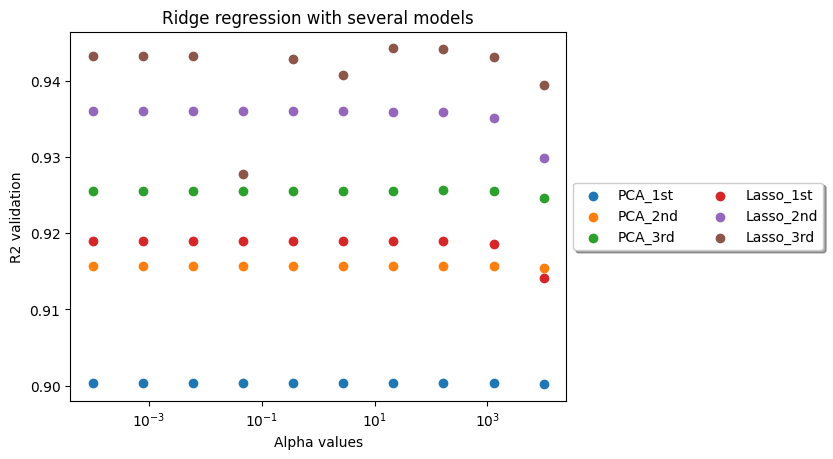

In [94]:
# 2D plot for 20 features using PCA
models = ['PCA_1st', 'PCA_2nd','PCA_3rd', 'Lasso_1st', 'Lasso_2nd','Lasso_3rd']
alpha_values = alpha_values_20_PCA
z_1st_PCA = results_20_linear_PCA['r2_validation']
z_2nd_PCA = results_20_second_PCA['r2_validation']
z_3rd_PCA = results_20_third_PCA['r2_validation']
z_1st_Lasso = results_20_linear_Lasso['r2_validation']
z_2nd_Lasso = results_20_second_Lasso['r2_validation']
z_3rd_Lasso = results_20_third_Lasso['r2_validation']
plot_2d(models, alpha_values, [z_1st_PCA, z_2nd_PCA, z_3rd_PCA, z_1st_Lasso, z_2nd_Lasso, z_3rd_Lasso])

### Plot R2 test of all the models

Text(0.5, 1.0, 'Ridge regression with several models')

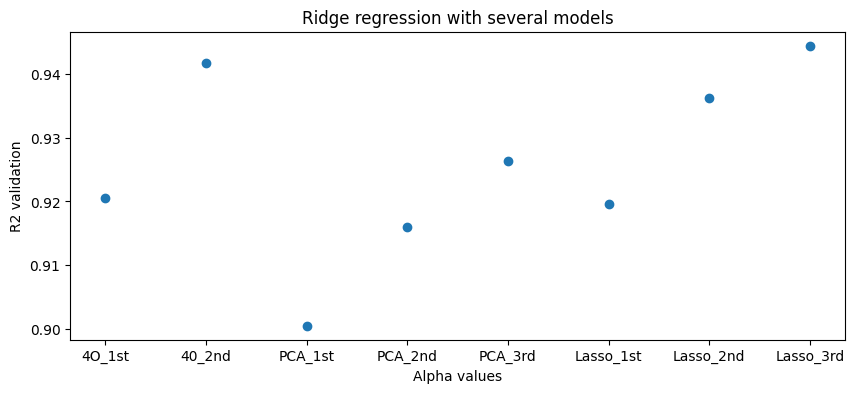

In [106]:
# Set up the plot
models = ['4O_1st', '40_2nd', 'PCA_1st', 'PCA_2nd','PCA_3rd', 'Lasso_1st', 'Lasso_2nd','Lasso_3rd']
r2_tests = [
    results_40_linear['r2_test'], results_40_second['r2_test'],
    results_20_linear_PCA['r2_test'], results_20_second_PCA['r2_test'],
    results_20_third_PCA['r2_test'], results_20_linear_Lasso['r2_test'],
    results_20_second_Lasso['r2_test'], results_20_third_Lasso['r2_test']
]
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(models, r2_tests)
ax.set_xlabel('Alpha values')
ax.set_ylabel('R2 validation')
ax.set_title('Ridge regression with several models')

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_lmd.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo IPSL" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ipsl.png?raw=1" style="display: inline-block"/>

<img alt="Logo E4C" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_e4c_final.png?raw=1" style="display: inline-block"/>

<img alt="Logo EP" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ep.png?raw=1" style="display: inline-block"/>

<img alt="Logo SU" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_su.png?raw=1" style="display: inline-block"/>

<img alt="Logo ENS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ens.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo CNRS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_cnrs.png?raw=1" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>